In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
if 'archive.zip' not in os.listdir('/content'):
  !cp '/content/drive/Shareddrives/[Peter and Jayden] MVRC 2023/.D. DATASET STUFF/kaggle dump/archive.zip' /content
  !unzip archive.zip

Mounted at /content/drive


In [ ]:
!pip install tensorflow tensorflow-probability pandas numpy Pillow scikit-learn
!pip install matplotlib seaborn keras
!pip install pydot
!pip install pydotplus
!apt-get update -y
!apt-get install graphviz -y
!pip install opencv-python
!pip install shap
!pip install wandb

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
import random

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint



In [ ]:
model_file = 'model6'
seed = 6
random.seed(seed)
keras.utils.set_random_seed(seed)

In [ ]:
# prompt: function if folder doesn't exist, create it

def create_folder_if_not_exists(folder_path):
  """
  Creates a folder if it doesn't exist.

  Args:
    folder_path: The path to the folder.
  """
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)


In [ ]:
# prompt: function to copy all files in folder to another folder

def copy_folder_contents(source_folder, destination_folder):
  """
  Copies all files from the source folder to the destination folder.

  Args:
    source_folder: The path to the source folder.
    destination_folder: The path to the destination folder.
  """

  # Create the destination folder if it doesn't exist.
  create_folder_if_not_exists(destination_folder)

  # Iterate through the files in the source folder.
  for filename in os.listdir(source_folder):
    # Construct the full path for the source and destination files.
    source_file = os.path.join(source_folder, filename)
    destination_file = os.path.join(destination_folder, filename)

    # Copy the file.
    shutil.copy(source_file, destination_file)

copy_folder_contents('/content/train/0', '/content/files/0')
copy_folder_contents('/content/train/3', '/content/files/3')
copy_folder_contents('/content/train/4', '/content/files/4')
copy_folder_contents('/content/test/0', '/content/files/0')
copy_folder_contents('/content/test/3', '/content/files/3')
copy_folder_contents('/content/test/4', '/content/files/4')
copy_folder_contents('/content/val/0', '/content/files/0')
copy_folder_contents('/content/val/3', '/content/files/3')
copy_folder_contents('/content/val/4', '/content/files/4')

In [ ]:
import cv2
import argparse
import numpy as pb
import glob
import os


def hist_equalization(img):
    """ Normal Histogram Equalization

    Args:
        img : image input with single channel

    Returns:
        : Equalized Image
    """
    array = pb.asarray(img)
    bin_cont = pb.bincount(array.flatten(), minlength=256)
    pixels = pb.sum(bin_cont)
    bin_cont = bin_cont / pixels
    cumulative_sumhist = pb.cumsum(bin_cont)
    map = pb.floor(255 * cumulative_sumhist).astype(pb.uint8)
    arr_list = list(array.flatten())
    eq_arr = [map[p] for p in arr_list]
    arr_back = pb.reshape(pb.asarray(eq_arr), array.shape)
    return arr_back


def ahe(img, rx=136, ry=185):
    """ Adaptive Histogram Equalization

    Args:
        img : image input with single channel
        rx (int, optional): to divide horizontal regions, Note: Should be divisible by image size in x . Defaults to 136.
        ry (int, optional): to divide vertical regions, Note: Should be divisible by image size in y. Defaults to 185.

    Returns:
        : Equalized Image
    """
    v = img
    img_eq = pb.empty((v.shape[0], v.shape[1]), dtype=pb.uint8)
    for i in range(0, v.shape[1], rx):
        for j in range(0, v.shape[0], ry):
            t = v[j:j + ry, i:i + rx]
            c = hist_equalization(t)
            img_eq[j:j + ry, i:i + rx] = c
    return img_eq


def convert(file_path, result_path):
    # file_path = '/root/val/0/*.png'
    # result_path = '/root/val2/Healthy'
    create_folder_if_not_exists(result_path)
    images = sorted(glob.glob(file_path))
    # print(images)
    for image in images:
        img = cv2.imread(image, 1)
        # Covert to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split((hsv))
        hist_v = hist_equalization(v)
        # Merge back the channel
        merged_hist = cv2.merge((h, s, hist_v))
        hist = cv2.cvtColor(merged_hist, cv2.COLOR_HSV2BGR)

        # Construct the output file name
        base_name = os.path.basename(image)
        output_file_name = os.path.join(result_path, base_name)

        # Save image in result path folder
        cv2.imwrite(output_file_name, hist)

#         ahe_v = ahe(v)
#         merged_ahe = cv2.merge((h, s, ahe_v))
#         ahe_img = cv2.cvtColor(merged_ahe, cv2.COLOR_HSV2BGR)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

In [ ]:
# convert('/content/train/0/*.png','/content/train_parsed/Healthy')
# convert('/content/train/3/*.png','/content/train_parsed/Moderate')
# convert('/content/train/4/*.png','/content/train_parsed/Severe')
# convert('/content/test/0/*.png','/content/test_parsed/Healthy')
# convert('/content/test/3/*.png','/content/test_parsed/Moderate')
# convert('/content/test/4/*.png','/content/test_parsed/Severe')
convert('/content/files/0/*.png', '/content/files_parsed/Healthy')
convert('/content/files/3/*.png', '/content/files_parsed/Moderate')
convert('/content/files/4/*.png', '/content/files_parsed/Severe')

In [ ]:
# prompt: function to split a folder with images in their category folder into a train and test folders

def split_folder(folder_path, train_ratio):
  """
  Splits a folder with images in their category folder into a train and test folders.

  Args:
    folder_path: The path to the folder containing the images.
    train_ratio: The ratio of images to be used for training (between 0 and 1).

  Returns:
    None
  """

  # Create the train and test folders.
  train_folder = os.path.join('/content', 'train_parsed')
  test_folder = os.path.join('/content', 'test_parsed')
  create_folder_if_not_exists(train_folder)
  create_folder_if_not_exists(test_folder)

  # Iterate through the categories in the folder.
  for category in os.listdir(folder_path):
    category_folder = os.path.join(folder_path, category)

    # Get a list of images in the category folder.
    images = os.listdir(category_folder)

    # Shuffle the list of images.
    random.shuffle(images)

    # Split the list of images into train and test sets.
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]

    # Copy the train images to the train folder.
    for image in train_images:
      source_path = os.path.join(category_folder, image)
      destination_path = os.path.join(train_folder, category, image)
      create_folder_if_not_exists(os.path.dirname(destination_path))
      shutil.copy(source_path, destination_path)

    # Copy the test images to the test folder.
    for image in test_images:
      source_path = os.path.join(category_folder, image)
      destination_path = os.path.join(test_folder, category, image)
      create_folder_if_not_exists(os.path.dirname(destination_path))
      shutil.copy(source_path, destination_path)

split_folder('/content/files_parsed', 0.8)


In [ ]:
import tensorflow_probability as tfp
tfpl = tfp.layers
tfd = tfp.distributions

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make default font size larger
plt.rcParams['font.size'] = 16

cnames = ['Healthy', 'Moderate', 'Severe']

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/train_parsed',
    image_size=(224, 224),
    batch_size=128,
    class_names=cnames,
    label_mode='categorical',
    shuffle=True)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/test_parsed',
    image_size=(224, 224),
    batch_size=32,
    class_names=cnames,
    label_mode='categorical',
    shuffle=False)

class_names = train_ds.class_names

Found 3670 files belonging to 3 classes.
Found 920 files belonging to 3 classes.


In [ ]:
train_ds = train_ds.map(lambda x, y: (x/255.0, y)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x/255.0, y)).prefetch(tf.data.AUTOTUNE)

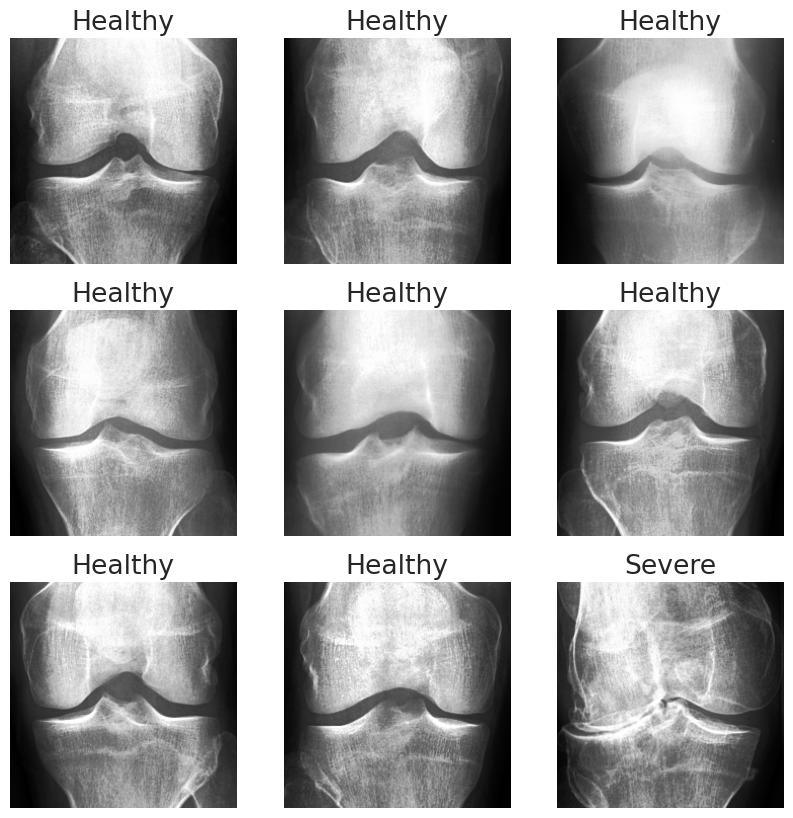

In [ ]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy())
        plt.title(class_names[np.argmax(label[i])])
        plt.axis('off')

In [ ]:
# !mkdir /content/augmented_images3
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your train folder path and output folder for augmented data
# train_folder = '/path/to/your/train/folder'
# output_folder = '/path/to/your/output/folder'
def augment_images(train_folder, output_folder):
  create_folder_if_not_exists(output_folder)
  # Create an ImageDataGenerator with desired augmentations
  datagen = ImageDataGenerator(
      rescale=1./255,
      horizontal_flip=True,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=(0.8, 1.2),
      shear_range=0.2,
      zoom_range=0.2
  )

  # Load X-ray images from the train folder
  train_generator = datagen.flow_from_directory(
      train_folder,
      target_size=(256, 256),  # Resize images to a consistent shape
      batch_size=32,
      class_mode='categorical',  # Adjust class mode based on your dataset
      # save_to_dir=output_folder,  # Save augmented images here
      save_prefix='aug_',  # Prefix for augmented filenames
      save_format='png',  # Save images in PNG format,
      seed=seed
  )
  return train_generator
  # # Generate augmented images and save them
  # num_augmented_images = 33  # Set the desired number of augmented images
  # for _ in range(num_augmented_images):
  #     batch = next(train_generator)
  #     if len(batch[0]) >= num_augmented_images:
  #         break

  print(f"Generated {len(os.listdir(output_folder))} augmented images.")
train_aug_gen = augment_images('/content/train_parsed', '/content/aug2/')

Found 3670 images belonging to 3 classes.


In [ ]:
# def balance(train_dir, working_dir, img_size):
#     aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
#     if os.path.isdir(aug_dir):# start with an empty directory
#         shutil.rmtree(aug_dir)
#     os.mkdir(aug_dir)
#     # create class directories within aug directory
#     labels=os.listdir(train_dir)
#     for label in labels:
#         dir_path=os.path.join(aug_dir,str(label))
#         os.mkdir(dir_path) # make class directories within aug directory
#     # create and store the augmented images
#     total=0
#     gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
#                                   height_shift_range=.2, zoom_range=.2)
#     for label in labels:  # for every class
#         # sample_count=len(group)   # determine how many samples there are in this class
#         sample_count=len(os.listdir(os.path.join(train_dir,label)))
#         n=len(sample_count)*4  # number of images in this class
#         if sample_count< n: # if the class has less than target number of images
#             aug_img_count=0
#             delta=n - sample_count  # number of augmented images to create
#             target_dir=os.path.join(aug_dir, str(label))  # define where to write the images
#             msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', list_of_classes[label], str(delta))
#             print(msg, '\r', end='') # prints over on the same line
#             aug_gen=gen.flow_from_directory( group,  x_col='filepaths', y_col=None, target_size=img_size,
#                                             class_mode=None, batch_size=1, shuffle=False,
#                                             save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
#                                             save_format='png')
#             while aug_img_count<delta:
#                 images=next(aug_gen)
#                 aug_img_count += len(images)
#             total +=aug_img_count
#     print('Total Augmented images created= ', total)
#     # create aug_df and merge with train_df to create composite training set ndf
#     aug_fpaths=[]
#     aug_labels=[]
#     classlist=os.listdir(aug_dir)
#     for klass in classlist:
#         classpath=os.path.join(aug_dir, klass)
#         flist=os.listdir(classpath)
#         for f in flist:
#             fpath=os.path.join(classpath,f)
#             aug_fpaths.append(fpath)
#             aug_labels.append(klass)
#     aug_labels = [int(i) for i in aug_labels]
#     Fseries=pd.Series(aug_fpaths, name='filepaths')
#     Lseries=pd.Series(aug_labels, name='labels')
#     aug_df=pd.concat([Fseries, Lseries], axis=1)
#     df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
#     print('Length of augmented dataframe is now ', len(df))
#     return df

# train_dir='/content/train_parsed'
# working_dir=r'./' # directory to store augmented images
# img_size=(224,224) # size of augmented images
# train_df=balance(train_dir, working_dir, img_size)

In [ ]:
# Check the class distributions
def get_classes(dataset: tf.data.Dataset) -> np.ndarray:
    counts = []
    for image, label in dataset:
        counts.append(np.argmax(label, axis=-1))
    return np.concatenate(counts)

train_classes = get_classes(train_ds)
test_classes = get_classes(test_ds)

train_classes.shape, test_classes.shape

((3670,), (920,))

In [ ]:
class_names_train = [class_names[i] for i in train_classes]
class_names_test = [class_names[i] for i in test_classes]
print(len(class_names_train))

3670


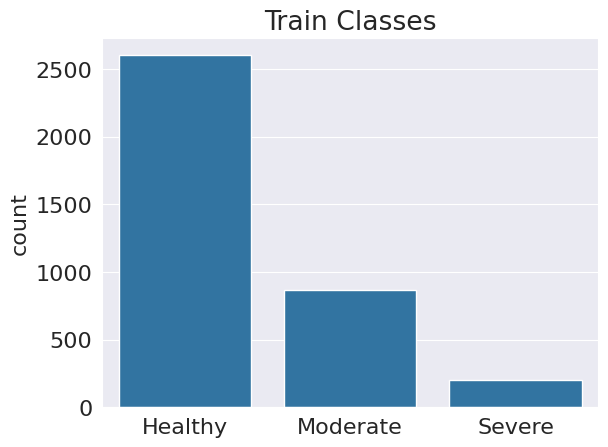

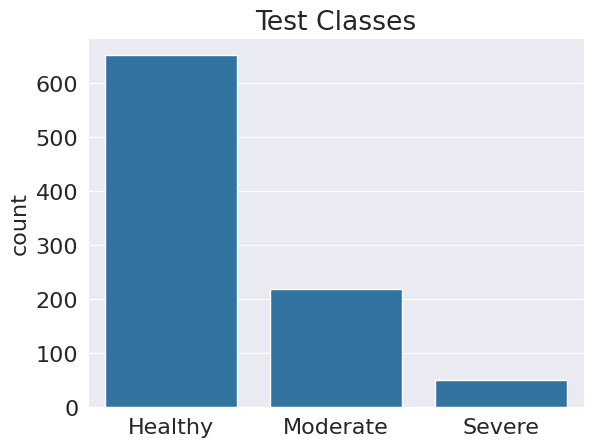

In [ ]:
# prompt: seaborn countplot of train and test side by side

sns.countplot(x=class_names_train, order=class_names)
plt.title('Train Classes')
plt.show()
sns.countplot(x=class_names_test, order=class_names)
plt.title('Test Classes')
plt.show()


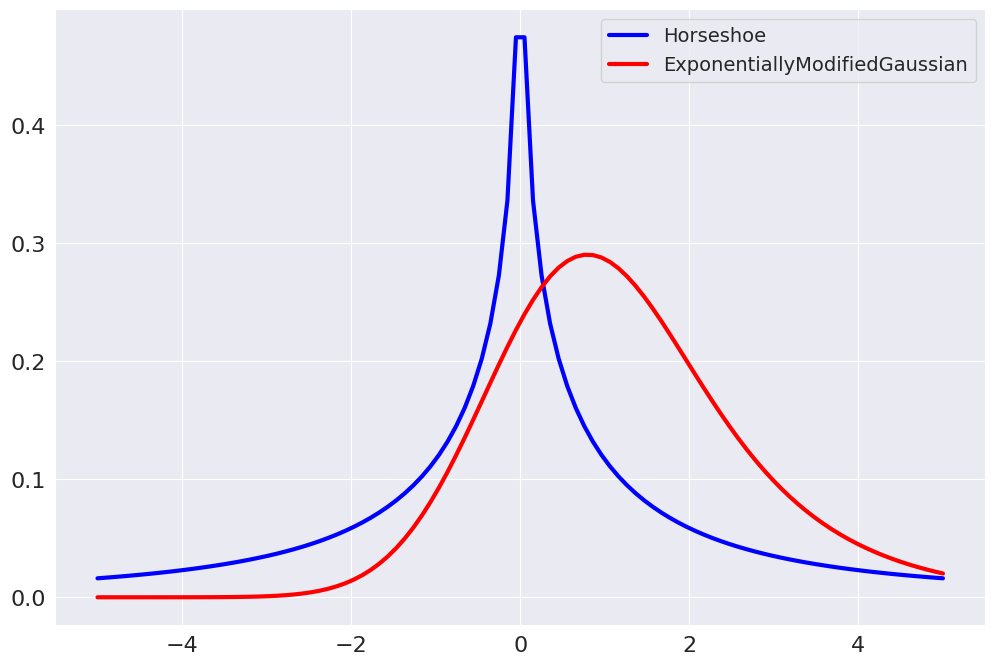

In [ ]:
def prior(dtype, shape, name, trainable, add_variable_fn):
    dist = tfd.MultivariateNormalDiag(loc=1.2 * tf.ones(shape), scale_diag=4.0*tf.ones(shape))
    # dist = tfd.Horseshoe(scale=[2.])
    # dist = tfd.ExponentiallyModifiedGaussian(loc = [0.],
    #                                          scale = [1.],
    #                                          rate = 0.8)

    batch_ndims = tf.size(dist.batch_shape_tensor())

    return tfd.Independent(dist, reinterpreted_batch_ndims=batch_ndims)

prior2  = tfd.Horseshoe(scale = [2.])
prior3 = tfd.ExponentiallyModifiedGaussian(loc = [0.],
                                             scale = [1.],
                                             rate = 0.8)

# def posterior(dtype, shape, name, trainable, add_variable_fn):
#     loc_scale_fn = tfp.layers.util.default_loc_scale_fn(untransformed_scale_initializer=tf.random_normal_initializer(mean=-0.1, stddev=0.1),
#                                                         loc_initializer=tf.random_normal_initializer(mean = -0.1, stddev=0.5))
#     loc, scale = loc_scale_fn(dtype, shape, name, trainable, add_variable_fn)

#     dist = tfd.ExponentiallyModifiedGaussian(loc = loc,
#                                              scale = scale,
#                                              rate = 1.2)

#     batch_ndims = tf.size(dist.batch_shape_tensor())
#     return tfd.Independent(dist, reinterpreted_batch_ndims=batch_ndims)

x = np.linspace(-5, 5, 100)
plt.figure(figsize=(12, 8))
plt.plot(x, prior2.prob(x), label='Horseshoe',
         color='blue', linewidth=3)
plt.plot(x, prior3.prob(x), label='ExponentiallyModifiedGaussian',
         color='red', linewidth=3)
plt.legend(fontsize = 14)
plt.show()

In [ ]:
def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / (len(train_classes))

In [ ]:
def get_convolution_reparameterization(
        filters,
        kernel_size,
        activation,
        strides = 1,
        padding = 'SAME',
        prior = prior,
        divergence_fn = divergence_fn,
        name = None) -> tfpl.Convolution2DReparameterization:
    """
    Returns a Convolution2DReparameterization layer.
    """
    return tfpl.Convolution2DReparameterization(
            filters = filters,
            kernel_size = kernel_size,
            activation = activation,
            strides = strides,
            padding = padding,

            kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            kernel_prior_fn=prior,
            kernel_divergence_fn=divergence_fn,

            bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
            bias_prior_fn=prior,
            bias_divergence_fn=divergence_fn,
            name=name)

def residual_block(x,
                   filters,
                   kernel_size,
                   padding,
                   activation,
                   pool_size,
                   strides,
                   name):
    # Include 3 convolutions, 2 normal & 1 residual.

    # For residual
    y = x

    # Conv + Act + BN
    x = get_convolution_reparameterization(
        filters = filters,
        kernel_size = kernel_size,
        activation = activation,
        strides = strides,
        padding = padding,
        name = name + '_reparam_conv1')(x)

    # Conv + Act + BN
    x = get_convolution_reparameterization(
        filters = filters,
        kernel_size = kernel_size,
        activation = activation,
        strides = strides,
        padding = padding,
            name = name + '_reparam_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name = name + '_batchnorm1')(x)

    # Residual Part
    y = get_convolution_reparameterization(
        filters = filters,
        kernel_size = (1, 1),
        activation = activation,
        strides = (1, 1),
        padding = padding,
        name = name + 'reparam_conv1_residual')(y)
    y = tf.keras.layers.BatchNormalization(name = name + 'residual_batchnorm1')(y)

    # Merge Part
    add_layer = tf.keras.layers.Add(name = name + '_merge_layer')([x, y])

    x = tf.keras.layers.MaxPooling2D(pool_size = pool_size,
                                     padding = padding,
                                     name = name + '_maxpool')(add_layer)

    return x

In [ ]:
feature_extractor = tf.keras.applications.DenseNet121(include_top = False,
                                                      input_shape = (224, 224, 3),
                                                      weights = 'imagenet')

In [ ]:
x = residual_block(feature_extractor.get_layer('conv5_block9_concat').output,
                   filters = 64,
                   kernel_size = 3,
                   padding = 'same',
                   activation = tf.nn.silu,
                   pool_size = (2, 2),
                   strides = (1, 1),
                   name = 'residual_block1')
x = residual_block(x,
                   filters = 128,
                   kernel_size = 3,
                   padding = 'same',
                   activation = tf.nn.silu,
                   pool_size = (2, 2),
                   strides = (1, 1),
                   name = 'residual_block2')

x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tfpl.DenseReparameterization(units = tfpl.CategoricalMixtureOfOneHotCategorical.params_size(3, 5),
                                 activation = None,

                                 kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                                 kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),

                                 bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                 bias_prior_fn=tfpl.default_multivariate_normal_fn,

                                 kernel_divergence_fn=divergence_fn,
                                 bias_divergence_fn=divergence_fn,
                                 name = 'dense_reparam')(x)

# CategoricalMixtureOfOneHotCategorical contains 5 OneHotCategorical layers.
# Event size: One sample from this layer will contain 2 classes,
# hence event_size = 2.
x = tfpl.CategoricalMixtureOfOneHotCategorical(event_size = 3,
                                               num_components = 5,
                                               convert_to_tensor_fn=tfp.distributions.Distribution.sample)(x)

model = tf.keras.Model(inputs = feature_extractor.input, outputs = x)
for layer in feature_extractor.layers:
    layer.trainable = False
model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [ ]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

tf.random.set_seed(seed)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = nll,
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy',
                                              patience = 20, restore_best_weights = False,
                                              verbose = 1),
             tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_categorical_accuracy',
                                                  min_lr=1e-9,
                                                  factor = 0.1,
                                                  patience = 8,
                                                  verbose = 1),
             tf.keras.callbacks.ModelCheckpoint(model_file+"_loss",
                            monitor="val_loss", mode="min",
                            save_best_only=True, verbose=1, save_weights_only=True),
             tf.keras.callbacks.ModelCheckpoint(model_file+"_best",
                            monitor="val_categorical_accuracy", mode="max",
                            save_best_only=True, verbose=1, save_weights_only=True),
]

In [ ]:
!wandb login '026b929a4ff3a0212568e720803b63b9e2ccc80c'

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
sweep_config = {
    'method': 'bayes', #grid, random, bayes
    'metric': {
      'name': 'val_categorical_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'min': 1e-6,
            'max': 1e-3

        },
        'epochs': {
            'min': 16,
            'max': 64
        },
        'steps': {
            'min': 32,
            'max': len(class_names_train)//32
        },
        'patience': {
            'min': 7,
            'max': 21
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="OA sweep5")

Create sweep with ID: re2v6ane
Sweep URL: https://wandb.ai/jaydenclim/OA%20sweep5/sweeps/re2v6ane


In [ ]:
def train(lr=1e-3, epochs=16, steps=32, patience=7):
    # Compile model like you usually do.
    tf.keras.backend.clear_session()
    x = residual_block(feature_extractor.get_layer('conv5_block9_concat').output,
                      filters = 64,
                      kernel_size = 3,
                      padding = 'same',
                      activation = tf.nn.silu,
                      pool_size = (2, 2),
                      strides = (1, 1),
                      name = 'residual_block1')
    x = residual_block(x,
                      filters = 128,
                      kernel_size = 3,
                      padding = 'same',
                      activation = tf.nn.silu,
                      pool_size = (2, 2),
                      strides = (1, 1),
                      name = 'residual_block2')

    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = tfpl.DenseReparameterization(units = tfpl.CategoricalMixtureOfOneHotCategorical.params_size(3, 5),
                                    activation = None,

                                    kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),

                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_prior_fn=tfpl.default_multivariate_normal_fn,

                                    kernel_divergence_fn=divergence_fn,
                                    bias_divergence_fn=divergence_fn,
                                    name = 'dense_reparam')(x)

    # CategoricalMixtureOfOneHotCategorical contains 5 OneHotCategorical layers.
    # Event size: One sample from this layer will contain 2 classes,
    # hence event_size = 2.
    x = tfpl.CategoricalMixtureOfOneHotCategorical(event_size = 3,
                                                  num_components = 5,
                                                  convert_to_tensor_fn=tfp.distributions.Distribution.sample)(x)

    model = tf.keras.Model(inputs = feature_extractor.input, outputs = x)
    for layer in feature_extractor.layers:
        layer.trainable = False
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = nll,
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

    # callback setup
    wandb_callbacks = [
        WandbMetricsLogger(log_freq=10),
        tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_categorical_accuracy',
                                                  min_lr=1e-9,
                                                  factor = 0.1,
                                                  patience = int(patience),
                                                  verbose = 1),
        # WandbModelCheckpoint(filepath="my_model_{epoch:02d}")
    ]

    model.fit(train_aug_gen,
                    steps_per_epoch = int(steps),
          epochs = int(epochs),
          validation_data = test_ds,
          callbacks = wandb_callbacks, use_multiprocessing=True)


def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep
        train(
            lr=wandb.config.learning_rate,
            epochs=wandb.config.epochs,
            steps=wandb.config.steps,
            patience=wandb.config.patience
        )

In [ ]:
tf.device('/device:GPU:0')

In [ ]:
wandb.agent("hgq5aop4", function=sweep_train, count=7)

wandb: Agent Starting Run: o9i9mjfp with config:
wandb: 	epochs: 34
wandb: 	learning_rate: 0.0005002786082750187
wandb: 	patience: 7
wandb: 	steps: 118
wandb: Currently logged in as: jaydenclim. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/34
118/118 [==============================] - 191s 1s/step - loss: 838.4736 - categorical_accuracy: 0.5743 - val_loss: 834.0743 - val_categorical_accuracy: 0.6033 - lr: 5.0000e-04
Epoch 2/34
118/118 [==============================] - 147s 1s/step - loss: 829.7137 - categorical_accuracy: 0.6152 - val_loss: 824.9208 - val_categorical_accuracy: 0.6598 - lr: 5.0000e-04
Epoch 3/34
118/118 [==============================] - 153s 1s/step - loss: 820.5206 - categorical_accuracy: 0.6745 - val_loss: 816.0312 - val_categorical_accuracy: 0.6924 - lr: 5.0000e-04
Epoch 4/34
118/118 [==============================] - 147s 1s/step - loss: 811.1859 - categorical_accuracy: 0.6938 - val_loss: 807.1517 - val_categorical_accuracy: 0.7011 - lr: 5.0000e-04
Epoch 5/34
118/118 [==============================] - 150s 1s/step - loss: 801.5887 - categorical_accuracy: 0.7215 - val_loss: 796.9818 - val_categorical_accuracy: 0.6239 - lr: 5.0000e-04
Epoch 6/34
118/118 [==============================] - 156s 1

batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/categorical_accuracy,▁▁▂▄▄▅▆▅▅▅▆▆▆▇▆▅▆▆▆▇▇▆▆▇▇▇▇▇▇█▇▇▇▇▇▆▇▇▇▇
batch/learning_rate,█████████████████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
batch/loss,███▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,▁▂▄▅▅▆▆▆▇▇▆▇▆▇▇▇▇▇▇▇██████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,█████████████████████▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/loss,██▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▄▄▂▆▅▆▅▆▆▆▅▇▅▆▆▇▇▆▇█▅▆▆▅█▇▇▅▅█▆▇
epoch/val_loss,██▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/batch_step,4070


wandb: Agent Starting Run: l6otiitm with config:
wandb: 	epochs: 38
wandb: 	learning_rate: 7.03803572252365e-05
wandb: 	patience: 16
wandb: 	steps: 128


Epoch 1/38
128/128 [==============================] - 207s 1s/step - loss: 838.0927 - categorical_accuracy: 0.5504 - val_loss: 833.5367 - val_categorical_accuracy: 0.5565 - lr: 5.0000e-04
Epoch 2/38


wandb: Ctrl + C detected. Stopping sweep.
Process Keras_worker_ForkPoolWorker-71:


In [ ]:
history = model.fit(train_aug_gen,
                    steps_per_epoch = len(class_names_train)//32,
          epochs = 64,
          validation_data = test_ds,
          callbacks = callbacks, use_multiprocessing=True)

Epoch 1/64
114/114 [==============================] - ETA: 0s - loss: 838.7023 - categorical_accuracy: 0.5660
Epoch 1: val_loss improved from inf to 834.45093, saving model to model6_loss

Epoch 1: val_categorical_accuracy improved from -inf to 0.57935, saving model to model6_best
114/114 [==============================] - 101s 707ms/step - loss: 838.7023 - categorical_accuracy: 0.5660 - val_loss: 834.4509 - val_categorical_accuracy: 0.5793 - lr: 5.0000e-04
Epoch 2/64
114/114 [==============================] - ETA: 0s - loss: 830.2872 - categorical_accuracy: 0.6132
Epoch 2: val_loss improved from 834.45093 to 826.00903, saving model to model6_loss

Epoch 2: val_categorical_accuracy improved from 0.57935 to 0.65217, saving model to model6_best
114/114 [==============================] - 81s 705ms/step - loss: 830.2872 - categorical_accuracy: 0.6132 - val_loss: 826.0090 - val_categorical_accuracy: 0.6522 - lr: 5.0000e-04
Epoch 3/64
114/114 [==============================] - ETA: 0s - loss

In [ ]:
!pip freeze > requirements.txt

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
model.save_weights('/content/drive/Shareddrives/[Peter and Jayden] MVRC 2023/Code/'+model_file+"_final")
model.load_weights('/content/'+model_file+"_best")
model.save_weights('/content/drive/Shareddrives/[Peter and Jayden] MVRC 2023/Code/'+model_file+"_best")
model.load_weights('/content/'+model_file+"_loss")
model.save_weights('/content/drive/Shareddrives/[Peter and Jayden] MVRC 2023/Code/'+model_file+"_loss")

In [ ]:
!cp '/content/drive/Shareddrives/[Peter and Jayden] MVRC 2023/Code/model6_best.index' '/content/'
!cp '/content/drive/Shareddrives/[Peter and Jayden] MVRC 2023/Code/model6_best.data-00000-of-00001' '/content/'
model.load_weights('/content/'+"model6"+"_best")

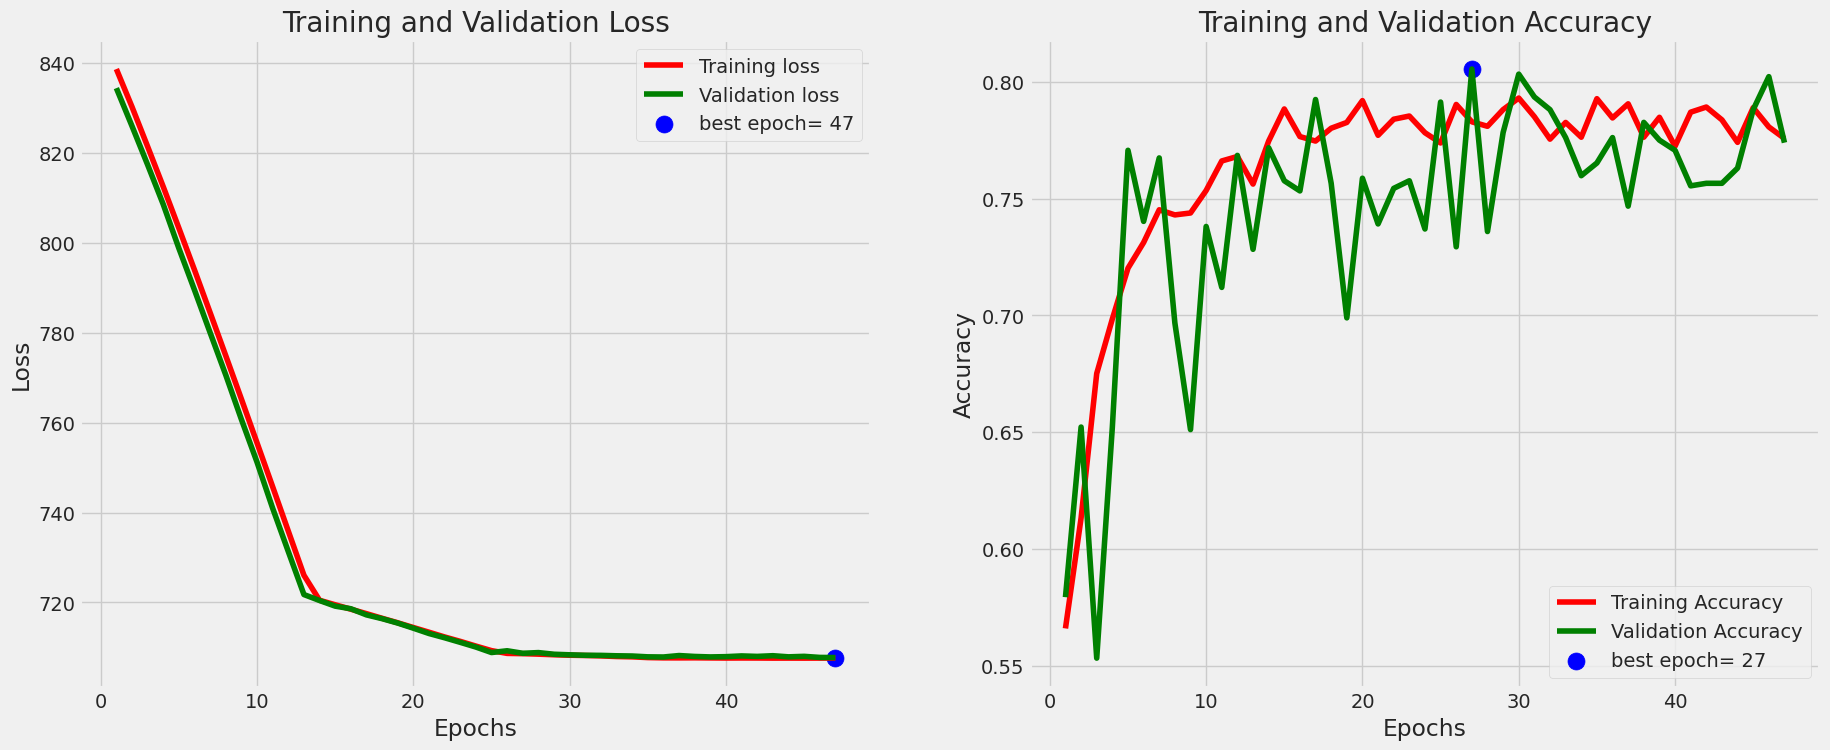

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['categorical_accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_categorical_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(history,0)

In [ ]:
test_samples = []
test_labels = []
for x, y in test_ds:
    test_samples.append(x.numpy())
    test_labels.append(y.numpy())

test_samples = np.concatenate(test_samples)
test_labels = np.concatenate(test_labels)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def analyse_model_prediction(image, label=None, forward_passes=10):
    if label is not None:
        label = np.argmax(label, axis=-1)

    # Adjusted for  3 categories
    extracted_probabilities = np.empty(shape=(forward_passes,  3))
    extracted_std = np.empty(shape=(forward_passes,  3))

    for i in range(forward_passes):
        model_output_distribution = model(tf.expand_dims(image, axis=0))

        # Assuming the model outputs a CategoricalMixtureOfOneHotCategorical distribution
        # We sample from the distribution to get the probabilities for each category
        sample = model_output_distribution.sample()
        extracted_probabilities[i] = sample.numpy().flatten()

        # Calculate standard deviation for each category
        extracted_std[i] = np.std(extracted_probabilities[:i+1], axis=0)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,  6),
                                   gridspec_kw={'width_ratios': [2,  4]})
    plt.xticks(fontsize=16, rotation=45)
    plt.yticks(fontsize=16)

    # Show the image and the true label if provided.
    ax1.imshow(image.squeeze(), cmap='gray')
    ax1.axis('off')
    if label is not None:
        ax1.set_title('True Label: {}'.format(str(class_names[label])), fontsize=20)
    else:
        ax1.set_title('True Label Not Given', fontsize=20)

    # Obtain the  95% prediction interval.
    # Adjusted for  3 categories
    pct_2p5 = np.array([np.percentile(extracted_probabilities[:, i],  2.5) for i in range(3)])
    pct_97p5 = np.array([np.percentile(extracted_probabilities[:, i],  97.5) for i in range(3)])
    # if(pct_97p5)
    bar = ax2.bar(np.arange(3), pct_97p5, color='red')
    if label is not None:
        bar[label].set_color('green')

    ax2.bar(np.arange(3), pct_2p5-0.02, color='white', linewidth=4, edgecolor='white')
    plt.xticks(np.arange(3), labels=class_names)  # Assuming class_names is defined elsewhere

    ax2.set_ylim([0,  1])
    ax2.set_ylabel('Probability', fontsize=18)
    ax2.set_title("Model's Probabilities", fontsize=20)
    plt.show()


In [ ]:
for idx in range(200, len(class_names_test), 50):
    analyse_model_prediction(test_samples[idx], test_labels[idx])
    print("---" * 30)

In [ ]:
# from google.colab import runtime
# runtime.unassign()

In [ ]:
# prompt: model predict image given image path
model.load_weights('/content/'+model_file+"_best")

# image_path = '/content/train_parsed/Healthy/9001695L.png'
image_path = os.path.join('/content/train_parsed', 'Severe', os.listdir('/content/train_parsed/Severe')[7])
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = image / 255.0
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
predicted_class = np.argmax(predictions)

print("Predicted class:", class_names[predicted_class])


1/1 [==============================] - 4s 4s/step
Predicted class: Moderate


In [ ]:
!cat '/content/drive/Shareddrives/[Peter and Jayden] MVRC 2023/Code/checkpoint'

model_checkpoint_path: "model6_loss"
all_model_checkpoint_paths: "model6_loss"


In [ ]:
import numpy as np

# Extract data from the train_ds and test_ds
x_train, y_train = [], []
for x, y in train_ds:
    x_train.append(x.numpy())
    y_train.append(y.numpy())

x_test, y_test = [], []
for x, y in test_ds:
    x_test.append(x.numpy())
    y_test.append(y.numpy())

# Convert lists to numpy arrays
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Print the shapes of the resulting datasets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (3670, 224, 224, 3)
y_train shape: (3670, 3)
x_test shape: (920, 224, 224, 3)
y_test shape: (920, 3)


In [ ]:
import tensorflow as tf
import numpy as np
import shap

# Load Fashion MNIST dataset
# (X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()
# X_train, X_test = X_train.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1)
# X_train, X_test = X_train / 255.0, X_test / 255.0

# Define class labels
# class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Define your Bayesian CNN model (replace with your own model)
# model = keras.Sequential(...)
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Create a SHAP explainer
def predict_fn(X):
    return model.predict(X)

explainer = shap.Explainer(predict_fn, masker=shap.maskers.Image("inpaint_telea", x_train.shape))

# Compute SHAP values for a batch of test images
shap_values = explainer(x_test[:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

# Visualize SHAP values (image plots)
shap.image_plot(shap_values)


In [ ]:
# prompt: shap kernel explainer

import shap
import tensorflow as tf

# Load the model and data
# model = tf.keras.models.load_model('/content/drive/Shareddrives/[Peter and Jayden] MVRC 2023/Code/model6_best')
# X_train, X_test, y_train, y_test = shap.datasets.adult()

# Create a Shap explainer
explainer = shap.KernelExplainer(model, x_train)

# Select a random instance to explain
instance = x_test[0]

# Explain the model's prediction for the instance
shap_values = explainer.shap_values(instance)

# Visualize the Shap values
shap.summary_plot(shap_values, instance)


Provided model function fails when applied to the provided data set.


ResourceExhaustedError: Exception encountered when calling layer 'conv1/conv' (type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3670,112,112,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D] name: 

Call arguments received by layer 'conv1/conv' (type Conv2D):
  • inputs=tf.Tensor(shape=(3670, 230, 230, 3), dtype=float32)